# Airbnb Price Prediction




## Data Loading and Preprocessing

In [54]:
#@title Download airbnb data in LA
import os
import requests
import gzip
import shutil

# download file
url = "https://data.insideairbnb.com/united-states/ca/los-angeles/2024-09-04/data/listings.csv.gz"
filename = "listings.csv.gz"
output_filename = "listings.csv"

print("Downloading...")
response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(filename, 'wb') as f:
        f.write(response.content)
    print(f"{filename} downloaded successfully.")
else:
    print("Failed to download the file.")

# Unzip file
print("Extracting...")
with gzip.open(filename, 'rb') as f_in:
    with open(output_filename, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
print(f"File extracted to {output_filename}.")

print("\nFiles in current directory:")
print(os.listdir())

Downloading...
listings.csv.gz downloaded successfully.
Extracting...
File extracted to listings.csv.

Files in current directory:
['.config', 'listings.csv', 'listings.csv.gz', 'sample_data']


In [55]:
import pandas as pd
file_path = "listings.csv"
data = pd.read_csv(file_path)

In [56]:
pd.set_option('display.max_columns', None)
print(data.head())

                    id                                       listing_url       scrape_id last_scraped           source                                               name                                        description neighborhood_overview                                        picture_url    host_id                                     host_url host_name  host_since    host_location                                         host_about  host_response_time host_response_rate host_acceptance_rate host_is_superhost                                 host_thumbnail_url                                   host_picture_url host_neighbourhood  host_listings_count  host_total_listings_count  host_verifications host_has_profile_pic host_identity_verified neighbourhood neighbourhood_cleansed  \
0   670339032744709144   https://www.airbnb.com/rooms/670339032744709144  20240904164210   2024-09-05      city scrape     Westwood lovely three bedrooms three bathrooms  The whole group will enjoy easy access

In [57]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45533 entries, 0 to 45532
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            45533 non-null  int64  
 1   listing_url                                   45533 non-null  object 
 2   scrape_id                                     45533 non-null  int64  
 3   last_scraped                                  45533 non-null  object 
 4   source                                        45533 non-null  object 
 5   name                                          45532 non-null  object 
 6   description                                   44100 non-null  object 
 7   neighborhood_overview                         23112 non-null  object 
 8   picture_url                                   45533 non-null  object 
 9   host_id                                       45533 non-null 

In [58]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 800)

feature_stats = pd.DataFrame({
    "Total": data.shape[0],
    "Non-Null Count": data.count(),
    "Missing Count": data.isnull().sum(),
    "Missing Percentage": (data.isnull().sum() / data.shape[0]) * 100
}).sort_values(by="Missing Count", ascending=False)

print(feature_stats)

                                              Total  Non-Null Count  Missing Count  Missing Percentage
calendar_updated                              45533               0          45533          100.000000
license                                       45533           12803          32730           71.881932
neighborhood_overview                         45533           23112          22421           49.241210
neighbourhood                                 45533           23113          22420           49.239013
host_about                                    45533           24642          20891           45.881009
review_scores_value                           45533           33368          12165           26.716887
review_scores_location                        45533           33369          12164           26.714690
review_scores_checkin                         45533           33370          12163           26.712494
review_scores_communication                   45533           33377      

### Data cleaning

1. Make subjective judgments and delete useless columns, such as id, name, url, description (NLP will not be used).
2. Remove columns with large amounts of missing data (more than 30%)
3. Each feature type is different and needs to be processed specifically. Categorical features need to be encoded, binary features need to be converted to 0/1, and price needs to remove the currency symbol.



Future research:
We can try to preserve text information

In [59]:
# Step 1: Remove Predefined Useless Columns
columns_to_drop = [
    'id', 'listing_url', 'scrape_id', 'last_scraped', 'source',
    'name', 'description', 'neighborhood_overview', 'picture_url',
    'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
    'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
    'host_verifications', 'bathrooms_text', 'calendar_updated',
    'calendar_last_scraped', 'first_review', 'last_review', 'license'
]
data = data.drop(columns=columns_to_drop, errors='ignore')  # Use errors='ignore' to avoid issues if columns are missing

# Step 2: Remove Columns with >30% Missing Data
missing_threshold = 0.3
missing_data = data.isnull().mean()  # Calculate the percentage of missing values
columns_to_drop_missing = missing_data[missing_data > missing_threshold].index
data = data.drop(columns=columns_to_drop_missing, errors='ignore')  # Use errors='ignore' for safety

# Step 3: Log Dropped Columns (Optional)
dropped_columns = list(columns_to_drop) + list(columns_to_drop_missing)
print(f"Dropped columns: {dropped_columns}")

# Resulting DataFrame Summary
print(f"Remaining columns: {data.columns.tolist()}")
print(f"Shape of cleaned dataset: {data.shape}")


Dropped columns: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'bathrooms_text', 'calendar_updated', 'calendar_last_scraped', 'first_review', 'last_review', 'license', 'neighbourhood']
Remaining columns: ['host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_

### Addressing missing values

 1. Binary Features
- **Columns**: `host_is_superhost`, `host_has_profile_pic`, `host_identity_verified`, `has_availability`, `instant_bookable`.
- **Steps**:
  - Map `'t'` → `1`, `'f'` → `0`.
  - Fill missing values with `0` since missing values for these columns usually mean they are not superhost, doesn't have profile pic, etc..

 2. Percentage Features
- **Columns**: `host_response_rate`, `host_acceptance_rate`.
- **Steps**:
  - Remove `%` symbols and convert to `float`.
  - Fill missing values with the column median.

 3. Price Feature
- **Steps**:
  - Remove `$` and commas, convert to `float`.

 4. Categorical Features
- **Columns**: `host_response_time`, `neighbourhood_cleansed`, `neighbourhood_group_cleansed`, `property_type`, `room_type`.
- **Steps**:
  - Convert missing values to `"unknown"`.
  - Apply `LabelEncoder` for numeric encoding.
  - Store encoders for future use.

In [60]:
# Binary Features
binary_features = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
                   'has_availability', 'instant_bookable']
for col in binary_features:
    data[col] = data[col].map({'t': 1, 'f': 0})
    # For binary features, missing can reasonably be filled with 0
    data[col] = data[col].fillna(0)

# Percentage Features
percentage_features = ['host_response_rate', 'host_acceptance_rate']
for feature in percentage_features:
    data[feature] = data[feature].replace('[\%,]', '', regex=True).astype(float)
    # Use the median to fill missing values for percentages
    median_value = data[feature].median()
    data[feature] = data[feature].fillna(median_value)

# Price Feature
data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)



# Categorical Features
from sklearn.preprocessing import LabelEncoder
categorical_features = ['host_response_time', 'neighbourhood_cleansed',
                        'neighbourhood_group_cleansed', 'property_type', 'room_type']
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    data[feature] = data[feature].astype(str)  # Convert NaN to "unknown"
    data[feature] = le.fit_transform(data[feature])
    label_encoders[feature] = le


In [61]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45533 entries, 0 to 45532
Data columns (total 49 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_response_time                            45533 non-null  int64  
 1   host_response_rate                            45533 non-null  float64
 2   host_acceptance_rate                          45533 non-null  float64
 3   host_is_superhost                             45533 non-null  float64
 4   host_listings_count                           45531 non-null  float64
 5   host_total_listings_count                     45531 non-null  float64
 6   host_has_profile_pic                          45533 non-null  float64
 7   host_identity_verified                        45533 non-null  float64
 8   neighbourhood_cleansed                        45533 non-null  int64  
 9   neighbourhood_group_cleansed                  45533 non-null 

 5. Amenities Feature
- **Steps**:
  - Strip brackets (`[]`) and quotes (`"`) from the `amenities` column.
  - Split the string into a list of amenities.
  - Create a new column `amenities_length` to store the count of amenities.
  - Drop the original `amenities` column after transformation.


In [62]:
data['amenities'] = data['amenities'].str.strip('[]').str.replace('"', '').str.split(', ')
data['amenities_length'] = data['amenities'].apply(len)
data.drop(columns=['amenities'], inplace=True)

In [63]:
print(data.head())

   host_response_time  host_response_rate  host_acceptance_rate  host_is_superhost  host_listings_count  host_total_listings_count  host_has_profile_pic  host_identity_verified  neighbourhood_cleansed  neighbourhood_group_cleansed   latitude   longitude  property_type  room_type  accommodates  bathrooms  bedrooms  beds  price  minimum_nights  maximum_nights  minimum_minimum_nights  maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  minimum_nights_avg_ntm  maximum_nights_avg_ntm  has_availability  availability_30  availability_60  availability_90  availability_365  number_of_reviews  number_of_reviews_ltm  number_of_reviews_l30d  review_scores_rating  review_scores_accuracy  review_scores_cleanliness  review_scores_checkin  review_scores_communication  \
0                   3                96.0                  41.0                0.0                173.0                      194.0                   1.0                     1.0                     252               

6. Price Outlier Handling and Missing Value Imputation
- **Steps**:
  1. Drop rows where `price` is an outlier:
     - Calculate bounds using the IQR method:
       - Lower bound: `Q1 - 1.5 * IQR`.
       - Upper bound: `Q3 + 1.5 * IQR`.
     - Retain rows within bounds or with missing `price`.
  2. Fill missing values in `price` with the knn imputation to prevent crowding the data with mean or median:
     - Compute the price using knn imputation with most relevant features after outlier removal.
     - Replace `NaN` in `price` with computed price


In [64]:
# Step 1: Drop Outliers for Rows without Missing Values in 'price'
# Exclude rows with missing 'price'
non_missing_price_data = data.dropna(subset=['price'])

# Calculate bounds for non-missing data
Q1 = non_missing_price_data['price'].quantile(0.25)
Q3 = non_missing_price_data['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Drop outliers (only for rows with non-missing price)
data = data[
    (data['price'].isnull()) |  # Keep rows where 'price' is missing
    ((data['price'] >= lower_bound) & (data['price'] <= upper_bound))  # Keep non-outlier rows
]

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Select features for KNN Imputation
features_for_imputation = ['bedrooms', 'room_type', 'amenities_length',
                           'beds', 'bathrooms', 'accommodates', 'property_type', 'price']

# Filter relevant columns
knn_data = data[features_for_imputation]

# Scale the data (important for KNN to handle numerical differences effectively)
scaler = StandardScaler()
knn_data_scaled = scaler.fit_transform(knn_data)

# Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5, weights='distance')  # Use distance-weighted neighbors

# Apply KNN Imputation
knn_data_imputed = knn_imputer.fit_transform(knn_data_scaled)

# Inverse transform to get back to original scale
knn_data_imputed = scaler.inverse_transform(knn_data_imputed)

# Replace the 'price' column with the imputed values
data['price'] = knn_data_imputed[:, -1]

# Verify the result
print(f"Missing values in 'price' after KNN Imputation: {data['price'].isnull().sum()}")


# Final Output
print(f"Shape of dataset after outlier removal and filling missing values: {data.shape}")
print(f"Missing values in 'price' after processing: {data['price'].isnull().sum()}")


Missing values in 'price' after KNN Imputation: 0
Shape of dataset after outlier removal and filling missing values: (42011, 49)
Missing values in 'price' after processing: 0


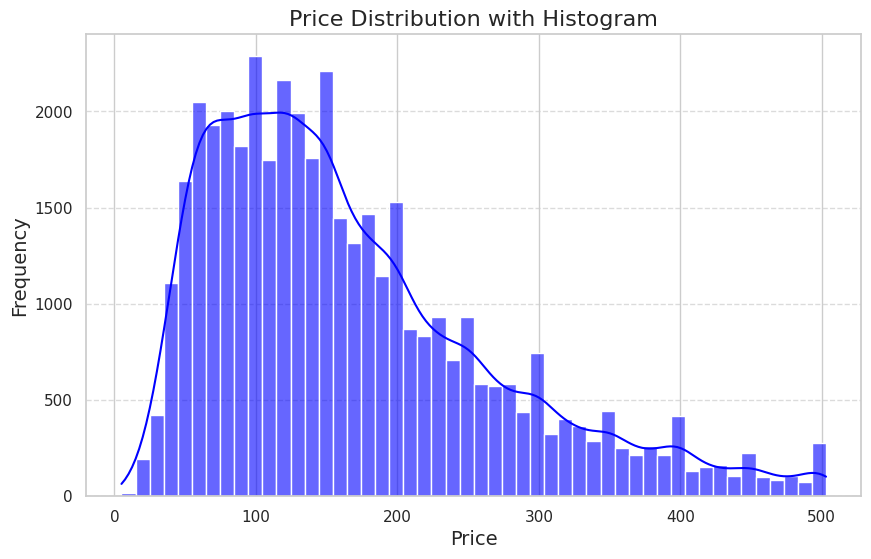

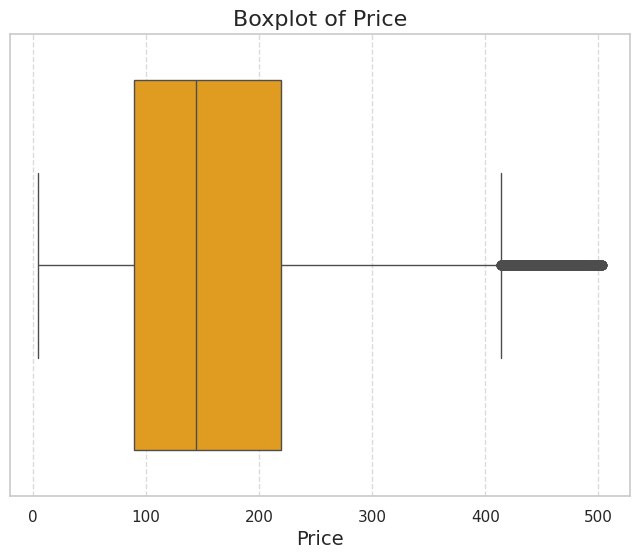

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a consistent style
sns.set(style="whitegrid")

# Figure 1: Histogram of Price
plt.figure(figsize=(10, 6))
sns.histplot(data['price'], bins=50, kde=True, color="blue", alpha=0.6)
plt.title("Price Distribution with Histogram", fontsize=16)
plt.xlabel("Price", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Figure 2: Boxplot of Price
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['price'], color="orange")
plt.title("Boxplot of Price", fontsize=16)
plt.xlabel("Price", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



In [66]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 800)

feature_stats = pd.DataFrame({
    "Total": data.shape[0],
    "Non-Null Count": data.count(),
    "Missing Count": data.isnull().sum(),
    "Missing Percentage": (data.isnull().sum() / data.shape[0]) * 100
}).sort_values(by="Missing Count", ascending=False)

print(feature_stats)

                                              Total  Non-Null Count  Missing Count  Missing Percentage
review_scores_value                           42011           31188          10823           25.762300
review_scores_location                        42011           31190          10821           25.757540
review_scores_checkin                         42011           31190          10821           25.757540
review_scores_communication                   42011           31194          10817           25.748018
review_scores_cleanliness                     42011           31194          10817           25.748018
review_scores_accuracy                        42011           31195          10816           25.745638
review_scores_rating                          42011           31197          10814           25.740877
reviews_per_month                             42011           31197          10814           25.740877
beds                                          42011           33682      


 **Columns**:
  - Review-related columns: `review_scores_value`, `review_scores_location`, `review_scores_checkin`, `review_scores_cleanliness`, `review_scores_communication`, `review_scores_accuracy`, `review_scores_rating`.
  - `reviews_per_month`.
- **Steps**:
  1. Create binary flags (`{col}_missing_flag`) for missing values in review-related columns and `reviews_per_month`.
  2. Impute missing values:
     - **Review Columns**: Fill missing values with the column median.
     - **`reviews_per_month`**: Assume `0` for missing values (no reviews).


 **Columns**: `beds`, `bathrooms`, `bedrooms`.
- **Steps**:
  1. Impute missing values using the column median.

In [67]:
# Step 1: Impute High Missing Columns
review_cols = ['review_scores_value', 'review_scores_location', 'review_scores_checkin',
               'review_scores_cleanliness', 'review_scores_communication', 'review_scores_accuracy', 'review_scores_rating']
for col in review_cols:
    data[col] = data[col].fillna(data[col].median())  # Use median for imputation

data['reviews_per_month'] = data['reviews_per_month'].fillna(0)  # Assume no reviews if missing

# Step 2: Impute Moderate Missing Columns
room_related_cols = ['beds', 'bathrooms', 'bedrooms']
for col in room_related_cols:
    data[col] = data[col].fillna(data[col].median())  # Use median





- **Columns**:
  - `minimum_nights_avg_ntm`, `maximum_nights_avg_ntm`, `minimum_minimum_nights`, `maximum_minimum_nights`, `minimum_maximum_nights`, `maximum_maximum_nights`, `host_listings_count`, `host_total_listings_count`.
- **Steps**:
  1. Drop rows where any of these columns have missing values since the missing rows are below 10.
  2. Verify that the specified columns no longer have missing values.


In [68]:
# List of columns with missing values to drop
columns_with_missing_values = [
    'minimum_nights_avg_ntm',
    'maximum_nights_avg_ntm',
    'minimum_minimum_nights',
    'maximum_minimum_nights',
    'minimum_maximum_nights',
    'maximum_maximum_nights',
    'host_listings_count',
    'host_total_listings_count'
]

# Drop rows with missing values in these columns
data = data.dropna(subset=columns_with_missing_values)

# Verify the dataset shape and confirm there are no missing values in these columns
print(f"Shape of dataset after dropping rows with missing values: {data.shape}")
print("Missing values in the specified columns after processing:")
print(data[columns_with_missing_values].isnull().sum())


Shape of dataset after dropping rows with missing values: (42002, 49)
Missing values in the specified columns after processing:
minimum_nights_avg_ntm       0
maximum_nights_avg_ntm       0
minimum_minimum_nights       0
maximum_minimum_nights       0
minimum_maximum_nights       0
maximum_maximum_nights       0
host_listings_count          0
host_total_listings_count    0
dtype: int64


In [69]:
print(data.isnull().sum())


host_response_time                              0
host_response_rate                              0
host_acceptance_rate                            0
host_is_superhost                               0
host_listings_count                             0
host_total_listings_count                       0
host_has_profile_pic                            0
host_identity_verified                          0
neighbourhood_cleansed                          0
neighbourhood_group_cleansed                    0
latitude                                        0
longitude                                       0
property_type                                   0
room_type                                       0
accommodates                                    0
bathrooms                                       0
bedrooms                                        0
beds                                            0
price                                           0
minimum_nights                                  0


In [70]:
print(data['price'].describe())



count    42002.000000
mean       166.750880
std        101.689338
min          5.000000
25%         90.000000
50%        144.000000
75%        219.400000
max        503.000000
Name: price, dtype: float64


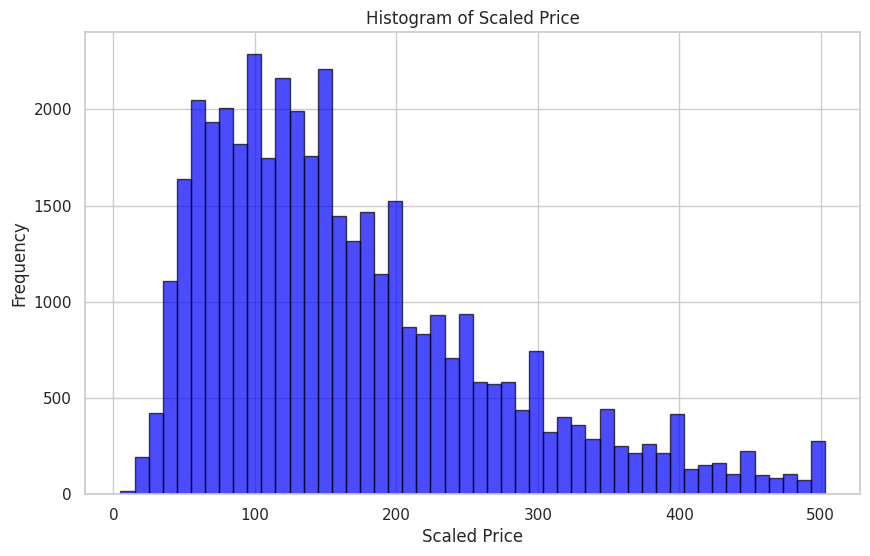

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(data['price'], bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title("Histogram of Scaled Price")
plt.xlabel("Scaled Price")
plt.ylabel("Frequency")
plt.show()


In [72]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 42002 entries, 0 to 45532
Data columns (total 49 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   host_response_time                            42002 non-null  int64  
 1   host_response_rate                            42002 non-null  float64
 2   host_acceptance_rate                          42002 non-null  float64
 3   host_is_superhost                             42002 non-null  float64
 4   host_listings_count                           42002 non-null  float64
 5   host_total_listings_count                     42002 non-null  float64
 6   host_has_profile_pic                          42002 non-null  float64
 7   host_identity_verified                        42002 non-null  float64
 8   neighbourhood_cleansed                        42002 non-null  int64  
 9   neighbourhood_group_cleansed                  42002 non-null  int6

## Linear Regression

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

X = data.drop(columns=['price'])  # Features
y = data['price']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 4831.240046563611
Root Mean Squared Error (RMSE): 69.50712227220755
Mean Absolute Error (MAE): 48.432955326293076


## Support Vector Regression (SVR)



In [74]:
from sklearn.svm import SVR

model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

MSE: 10961.96732183874
RMSE: 104.69941414276748
MAE: 77.94591618635003


## XGBoost Model

In [75]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize and train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mse_xgb ** 0.5
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print(f"XGBoost Mean Squared Error (MSE): {mse_xgb}")
print(f"XGBoost Root Mean Squared Error (RMSE): {rmse_xgb}")
print(f"XGBoost Mean Absolute Error (MAE): {mae_xgb}")


XGBoost Mean Squared Error (MSE): 2941.5031086292497
XGBoost Root Mean Squared Error (RMSE): 54.23562582499855
XGBoost Mean Absolute Error (MAE): 36.76702007063355


### XGBoost-Tune Hyperparameters

In [76]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8]
}

grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
best_xgb = grid_search.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}


### Refit the Model with Best Parameters

In [77]:
best_xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=8, random_state=42)
best_xgb_model.fit(X_train, y_train)

y_pred_best = best_xgb_model.predict(X_test)

mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = mse_best ** 0.5
mae_best = mean_absolute_error(y_test, y_pred_best)

print(f"Optimized XGBoost MSE: {mse_best}")
print(f"Optimized XGBoost RMSE: {rmse_best}")
print(f"Optimized XGBoost MAE: {mae_best}")


Optimized XGBoost MSE: 2721.9658509444307
Optimized XGBoost RMSE: 52.172462573127895
Optimized XGBoost MAE: 34.99605788958873


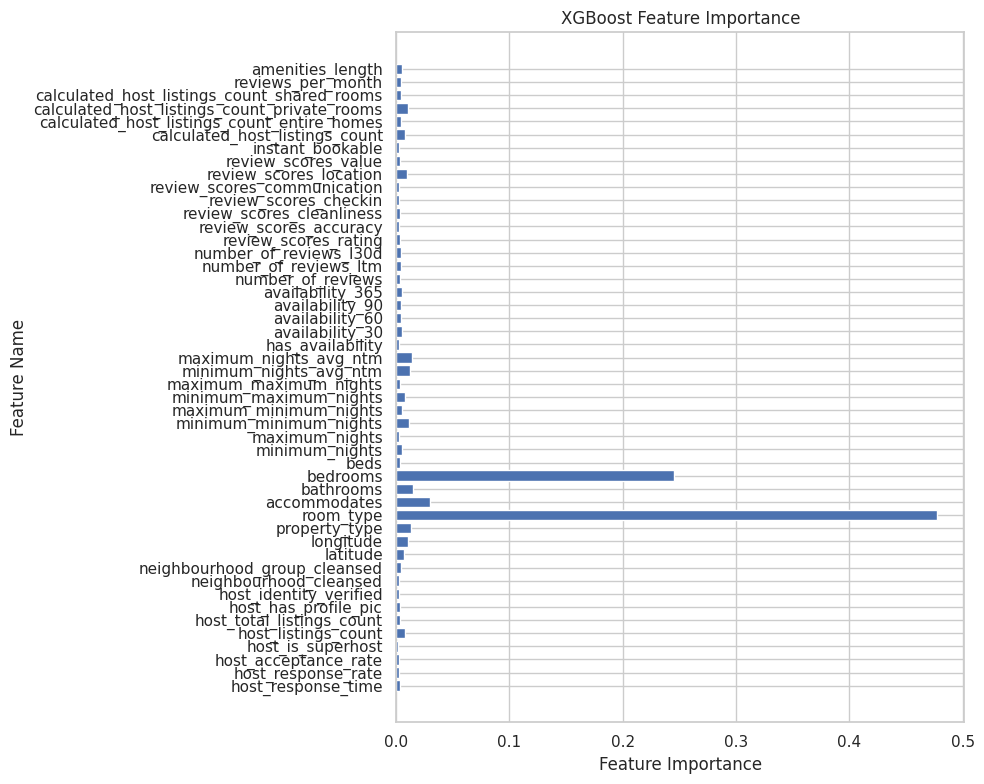

In [78]:
import matplotlib.pyplot as plt

# Plot feature importances
#plt.yticks(rotation=45)
plt.figure(figsize=(10, 8))  # Adjust figure size to make the plot larger
plt.barh(X_train.columns, best_xgb_model.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('XGBoost Feature Importance')
plt.tight_layout()  # Automatically adjust spacing to prevent overlapping
plt.show()


In [79]:
import pandas as pd

# Metrics from the initial XGBoost model
initial_metrics = {
    'Model': 'Initial XGBoost',
    'MSE': mse_xgb,
    'RMSE': rmse_xgb,
    'MAE': mae_xgb
}

# Metrics from the optimized XGBoost model
optimized_metrics = {
    'Model': 'Optimized XGBoost',
    'MSE': mse_best,
    'RMSE': rmse_best,
    'MAE': mae_best
}

# Create a DataFrame
comparison_df = pd.DataFrame([initial_metrics, optimized_metrics])
print(comparison_df)



               Model          MSE       RMSE        MAE
0    Initial XGBoost  2941.503109  54.235626  36.767020
1  Optimized XGBoost  2721.965851  52.172463  34.996058


## Random Forest Tree


In [80]:
#@title Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf}")

###
# Calculate RMSE
rmse_rf = mse_rf ** 0.5

# Calculate MAE
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf}")
print(f"Random Forest MAE: {mae_rf}")

Random Forest MSE: 2976.860016129709
Random Forest RMSE: 54.56060864882016
Random Forest MAE: 36.36765092333802


### Basic Random Forest Tree Model

In [81]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Step 1: Prepare Data
# Assume 'price' is the target variable and all other columns are features
X = data.drop(columns=['price'])  # Features
y = data['price']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Train a Basic Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions for train and test sets
y_train_pred = rf_model.predict(X_train).flatten()
y_test_pred = rf_model.predict(X_test).flatten()

# Calculate metrics for train set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display results
print("Random Forest Train Metrics:")
print(f"MSE: {train_mse:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"R-squared: {train_r2:.4f}")

print("\n Random Forest Test Metrics:")
print(f"MSE: {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R-squared: {test_r2:.4f}")


Random Forest Train Metrics:
MSE: 414.4073
RMSE: 20.3570
MAE: 13.4513
R-squared: 0.9599

 Random Forest Test Metrics:
MSE: 2976.8600
RMSE: 54.5606
MAE: 36.3677
R-squared: 0.7132


### Hyper Parameter Tuned Random Forest Model with Randomized Search CV

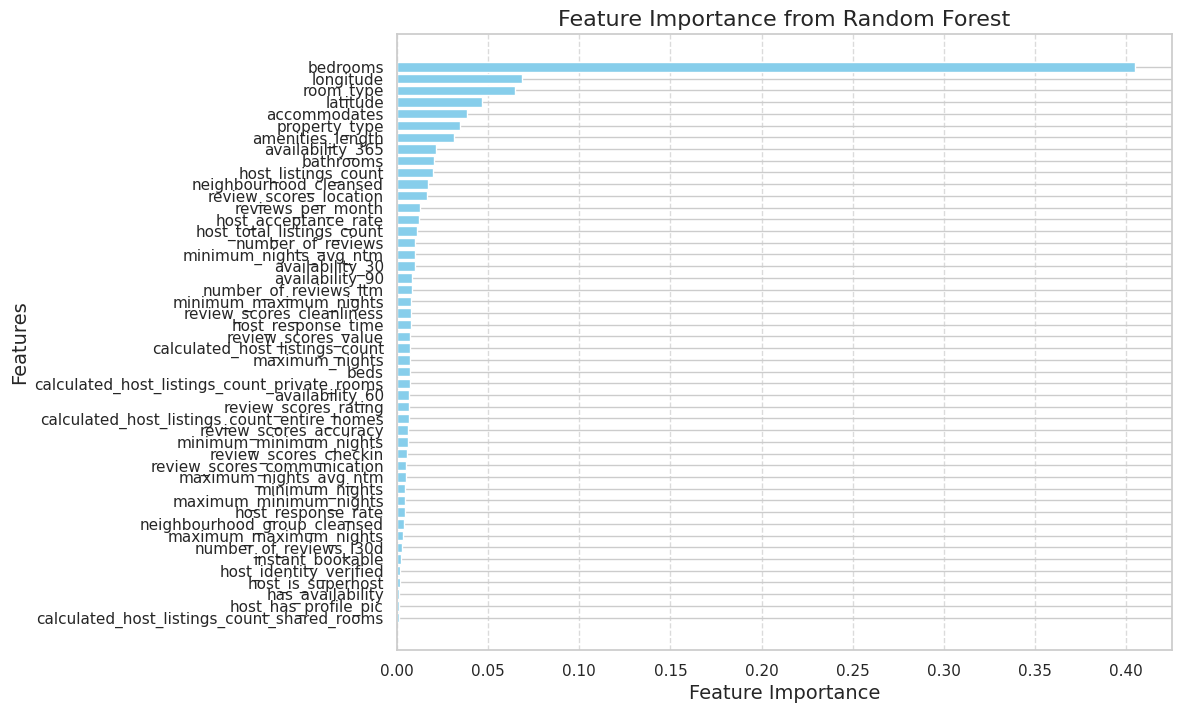

Feature Importance:
bedrooms: 0.4050
longitude: 0.0686
room_type: 0.0646
latitude: 0.0467
accommodates: 0.0386
property_type: 0.0344
amenities_length: 0.0312
availability_365: 0.0211
bathrooms: 0.0200
host_listings_count: 0.0196
neighbourhood_cleansed: 0.0168
review_scores_location: 0.0166
reviews_per_month: 0.0124
host_acceptance_rate: 0.0119
host_total_listings_count: 0.0108
number_of_reviews: 0.0100
minimum_nights_avg_ntm: 0.0100
availability_30: 0.0099
availability_90: 0.0083
number_of_reviews_ltm: 0.0082
minimum_maximum_nights: 0.0079
review_scores_cleanliness: 0.0074
host_response_time: 0.0074
review_scores_value: 0.0072
calculated_host_listings_count: 0.0072
maximum_nights: 0.0069
beds: 0.0069
calculated_host_listings_count_private_rooms: 0.0068
availability_60: 0.0067
review_scores_rating: 0.0067
calculated_host_listings_count_entire_homes: 0.0063
review_scores_accuracy: 0.0062
minimum_minimum_nights: 0.0058
review_scores_checkin: 0.0056
review_scores_communication: 0.0051
maxi

In [82]:
importances = rf_model.feature_importances_
feature_importance = sorted(zip(data.drop(columns=['price']).columns, importances), key=lambda x: x[1], reverse=True)
import matplotlib.pyplot as plt

# Extract feature names and importances
features = [feature for feature, importance in feature_importance]
importances = [importance for feature, importance in feature_importance]

# Create a bar plot for feature importance
plt.figure(figsize=(10, 8))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Feature Importance from Random Forest', fontsize=16)
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print("Feature Importance:")
for feature, importance in feature_importance:
    print(f"{feature}: {importance:.4f}")

In [83]:
low_importance_features = [feature for feature, importance in feature_importance if importance < 0.005]
data_no_low_feat = data.drop(columns=low_importance_features)
print(f"Dropped features: {low_importance_features}")


Dropped features: ['maximum_nights_avg_ntm', 'minimum_nights', 'maximum_minimum_nights', 'host_response_rate', 'neighbourhood_group_cleansed', 'maximum_maximum_nights', 'number_of_reviews_l30d', 'instant_bookable', 'host_identity_verified', 'host_is_superhost', 'has_availability', 'host_has_profile_pic', 'calculated_host_listings_count_shared_rooms']


In [84]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
import numpy as np

# Step 1: Prepare Data
X = data_no_low_feat.drop(columns=['price'])  # Features
y = data_no_low_feat['price']  # Target

# Split data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 20% of total data for validation

# Step 2: Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 300, 500],        # Number of trees
    'max_depth': [10, 20, None],            # Tree depth
    'min_samples_split': [2, 5, 10],        # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],          # Minimum samples required at a leaf node
    'max_features': ['sqrt', 'log2']        # Number of features to consider for splits
}

# Step 3: Initialize the Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Step 4: Define the scoring metric (e.g., negative MSE for regression)
scoring = make_scorer(mean_squared_error, greater_is_better=False)

# Step 5: Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           scoring=scoring,           # Use negative MSE as the scoring metric
                           verbose=2,                 # Print progress
                           n_jobs=-1,                 # Use all available CPU cores
                           cv=[(slice(None), slice(None))])  # Single validation split

# Step 6: Fit the model with the train-validation split
grid_search.fit(X_train, y_train)

# Step 7: Extract the best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert negative MSE back to positive MSE

print(f"Best Hyperparameters: {best_params}")
print(f"Validation MSE: {best_score:.4f}")

# Step 8: Evaluate the best model on the test set
best_model = grid_search.best_estimator_

# Train and Test Predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Step 9: Calculate Metrics for Train Set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Step 10: Calculate Metrics for Test Set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display Results
print("Random Forest Train Metrics:")
print(f"MSE: {train_mse:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"R-squared: {train_r2:.4f}")

print("\nRandom Forest Test Metrics:")
print(f"MSE: {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R-squared: {test_r2:.4f}")

Fitting 1 folds for each of 162 candidates, totalling 162 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Validation MSE: 418.9147
Random Forest Train Metrics:
MSE: 418.9147
RMSE: 20.4674
MAE: 13.9806
R-squared: 0.9594

Random Forest Test Metrics:
MSE: 3117.7958
RMSE: 55.8372
MAE: 38.2685
R-squared: 0.6996


## Neural Network

### Basic Neural Network with 5 hidden layers and 193 neurons

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 14326.9248 - mse: 14326.9248 - val_loss: 5028.3389 - val_mse: 5028.3389
Epoch 2/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 4594.4614 - mse: 4594.4614 - val_loss: 4877.1792 - val_mse: 4877.1792
Epoch 3/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4497.1631 - mse: 4497.1631 - val_loss: 4736.1509 - val_mse: 4736.1509
Epoch 4/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4431.3062 - mse: 4431.3062 - val_loss: 4737.3203 - val_mse: 4737.3203
Epoch 5/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4327.7915 - mse: 4327.7915 - val_loss: 4818.4028 - val_mse: 4818.4028
Epoch 6/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4257.7129 - mse: 4257.7129 - val_loss: 4719.9414 - val_mse: 4719.9414
Epoch 7/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 4276.1138 - mse: 4276.1138 - val_loss: 4602.7661 - val_mse: 4602.7661
Epoch 8/50
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4247.9492 - 

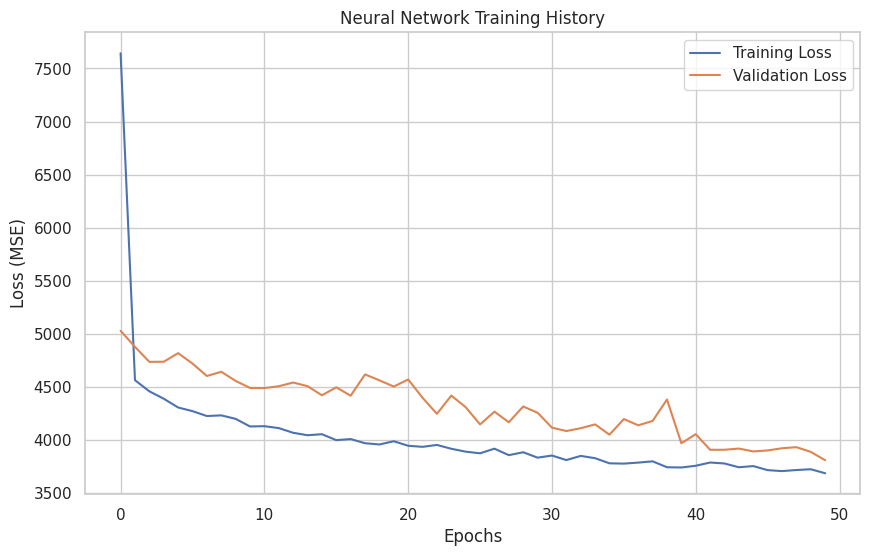

263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


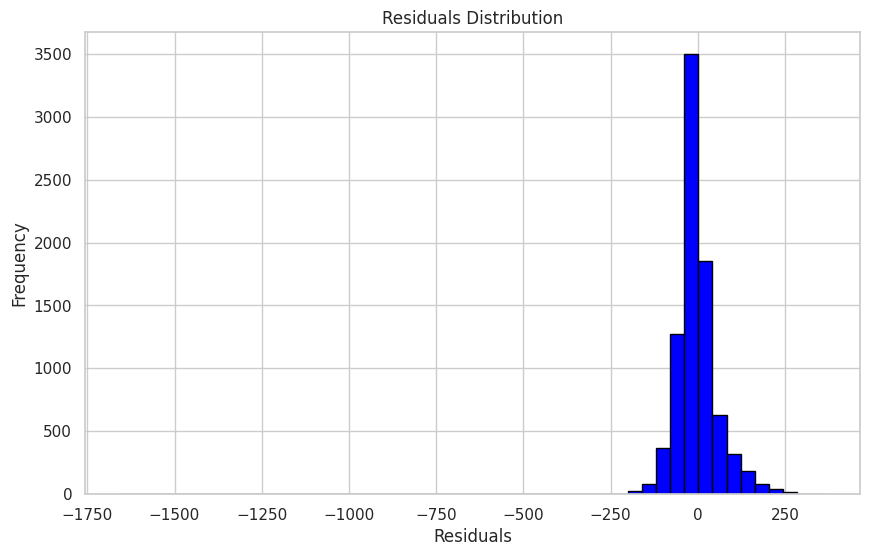

In [85]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Step 1: Prepare the Data
# Assuming 'price' is the target variable
X = data.drop(columns=['price'])  # Features
y = data['price']  # Target

# Scale the features for Neural Network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 2: Build the Neural Network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Input layer with 128 neurons
    Dropout(0.2),  # Dropout to prevent overfitting
    Dense(64, activation='relu'),  # Hidden layer with 64 neurons
    Dropout(0.2),  # Dropout
    Dense(1, activation='linear')  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Step 3: Train the Neural Network
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

# Step 4: Evaluate the Model
test_loss, test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Mean Squared Error (MSE): {test_mse}")

# Step 5: Visualize Training History
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Step 6: Predictions and Residuals
y_pred = model.predict(X_test)
residuals = y_test - y_pred.flatten()

# Plot residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, color='blue', edgecolor='black')
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions for train and test sets
y_train_pred = model.predict(X_train).flatten()
y_test_pred = model.predict(X_test).flatten()

# Calculate metrics for train set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display results
print("Train Metrics:")
print(f"MSE: {train_mse:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"R-squared: {train_r2:.4f}")

print("\nTest Metrics:")
print(f"MSE: {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R-squared: {test_r2:.4f}")


1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Train Metrics:
MSE: 3195.8124
RMSE: 56.5315
MAE: 39.4964
R-squared: 0.6907

Test Metrics:
MSE: 3809.3589
RMSE: 61.7200
MAE: 41.6339
R-squared: 0.6329


### Hyper-parameter tuned Neural Network with 7 layers and 449 neurons

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1051/1051 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 9825.1348 - mse: 9824.8008 - val_loss: 4923.4800 - val_mse: 4923.0962 - learning_rate: 0.0010
Epoch 2/200
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 4490.3135 - mse: 4489.9224 - val_loss: 4757.5596 - val_mse: 4757.1406 - learning_rate: 0.0010
Epoch 3/200
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4337.2578 - mse: 4336.8330 - val_loss: 4969.2886 - val_mse: 4968.8325 - learning_rate: 0.0010
Epoch 4/200
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4245.8926 - mse: 4245.4307 - val_loss: 4730.0864 - val_mse: 4729.5928 - learning_rate: 0.0010
Epoch 5/200
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4177.7930 - mse: 4177.2930 - val_loss: 4581.5630 - val_mse: 4581.0400 - learning_rate: 0.0010
Epoch 6/200
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4056.9155 - mse: 4056.3782 - val_loss: 4477.1655 - val_mse: 4476.5986 - learning_rate: 0.0010
Epoch 7/200
1051/1051 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4158.26

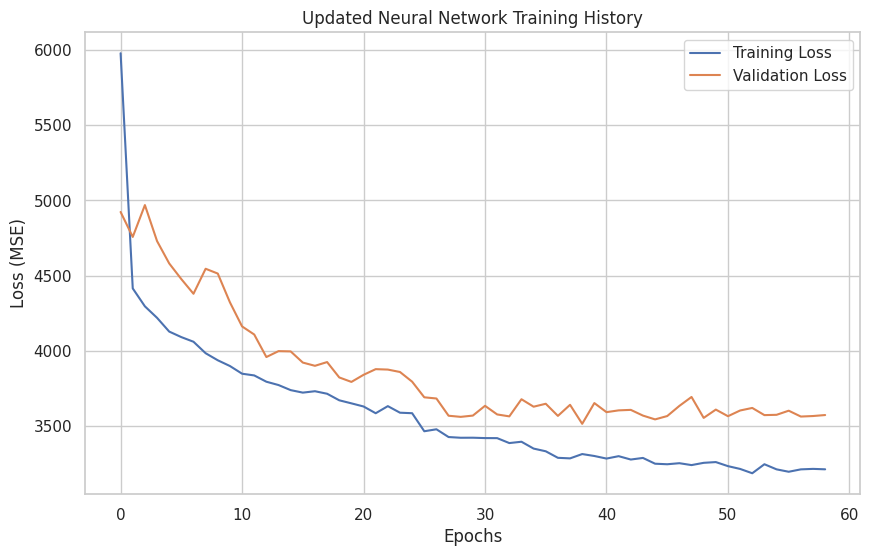

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Step 1: Prepare the Data
# Assuming 'price' is the target variable
X = data.drop(columns=['price'])  # Features
y = data['price']  # Target

# Scale the features for Neural Network
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build the updated Neural Network
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')
])

# Compile the model with Adam optimizer and MSE loss
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200,
                    batch_size=32, callbacks=[early_stopping, lr_scheduler])

# Evaluate the model
test_loss, test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Mean Squared Error (MSE): {test_mse}")

# Visualize training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Updated Neural Network Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [88]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predictions for train and test sets
y_train_pred = model.predict(X_train).flatten()
y_test_pred = model.predict(X_test).flatten()

# Calculate metrics for train set
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

# Calculate metrics for test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Display results
print("Train Metrics:")
print(f"MSE: {train_mse:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE: {train_mae:.4f}")
print(f"R-squared: {train_r2:.4f}")

print("\nTest Metrics:")
print(f"MSE: {test_mse:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"R-squared: {test_r2:.4f}")


1051/1051 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Train Metrics:
MSE: 2925.2027
RMSE: 54.0851
MAE: 36.5542
R-squared: 0.7169

Test Metrics:
MSE: 3513.9608
RMSE: 59.2787
MAE: 39.1428
R-squared: 0.6614


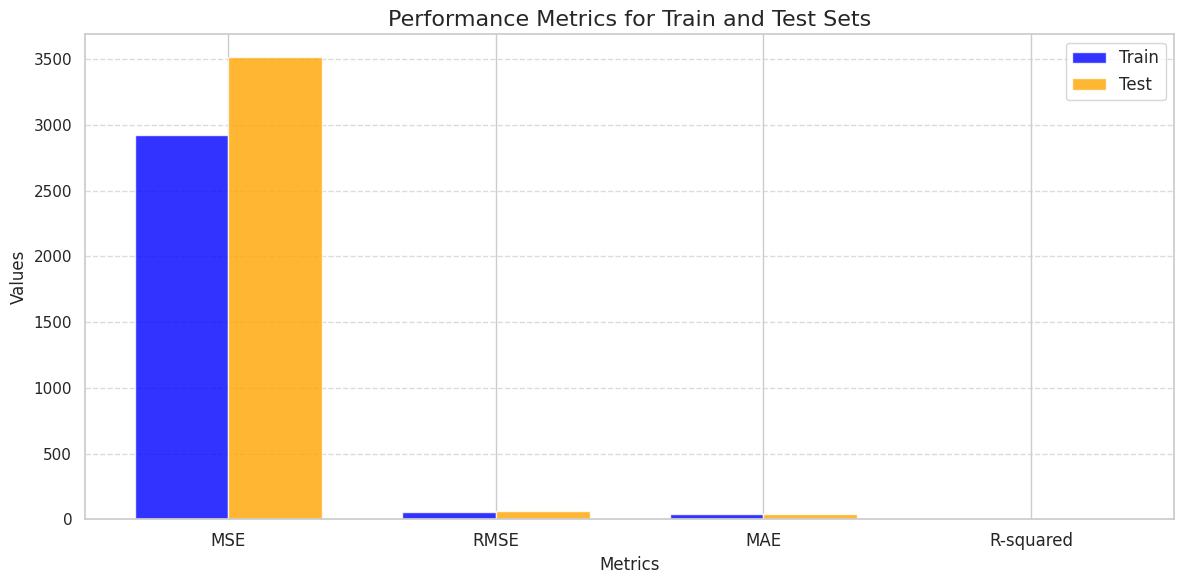

In [89]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data for the bar plot
metrics_data = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'R-squared'],
    'Train': [train_mse, train_rmse, train_mae, train_r2],
    'Test': [test_mse, test_rmse, test_mae, test_r2]
}

metrics_df = pd.DataFrame(metrics_data)

# Plot the metrics
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = range(len(metrics_df['Metric']))

# Bar plots for train and test metrics
plt.bar(index, metrics_df['Train'], bar_width, label='Train', alpha=0.8, color='blue')
plt.bar([i + bar_width for i in index], metrics_df['Test'], bar_width, label='Test', alpha=0.8, color='orange')

# Customization
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Performance Metrics for Train and Test Sets', fontsize=16)
plt.xticks([i + bar_width / 2 for i in index], metrics_df['Metric'], fontsize=12)
plt.legend(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


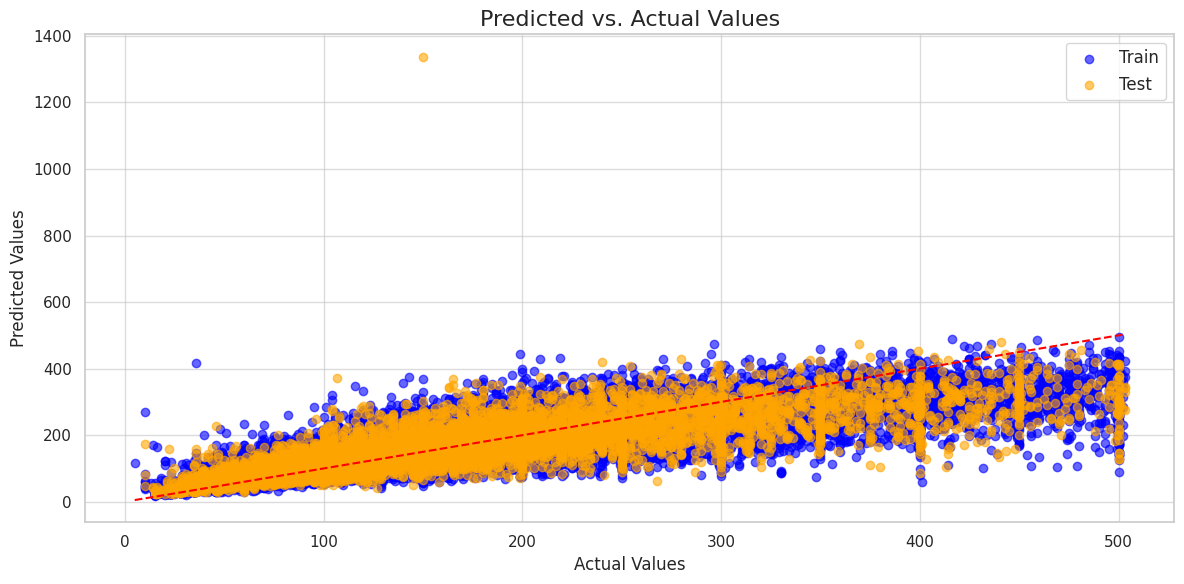

In [90]:
# Scatter plot for train set
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_train_pred, alpha=0.6, label='Train', color='blue')
plt.scatter(y_test, y_test_pred, alpha=0.6, label='Test', color='orange')

# Plot diagonal line for perfect predictions
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='red', linestyle='--')

# Customization
plt.title('Predicted vs. Actual Values', fontsize=16)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.7)
plt.tight_layout()
plt.show()
